In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

#### Functions

In [242]:
from aeons.toy_samples import gaussian_samples
from scipy.special import gammainc, gamma, logsumexp, loggamma, gammaincinv
def logZlive_formula(Xi, theta):
    # Without logLmax
    logLmax, d, sigma = theta
    prefactor = d/2*np.log(2) + d*np.log(sigma) + np.log(d/2)
    loggammainc = np.log( gammainc( d/2 , Xi**(2/d)/(2*sigma**2) ) * gamma(d/2) )
    return prefactor + loggammainc

def logXf_formula_approx(logZlive, logZdead, theta, epsilon=1e-3):
    logLmax = theta[0]
    return logsumexp([logZlive, logZdead - logLmax]) + np.log(epsilon)

def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

def end_iteration(samples, N, start=0.5, epsilon=1e-3):
    iterations = np.linspace(len(samples) * start, len(samples), N, endpoint=False).astype(int)
    for ndead in iterations:
        ndead = int(ndead)
        points = points_at_iteration(samples, ndead)
        weights = points.get_weights()
        if weights[ndead:].sum()/weights.sum() < epsilon:
            return ndead

def minimise_bandwidth(logL, X_mean, ndead, alphas, x0, warnings=False, give_alpha=False):
    theta_best = analytic_lm_params(logL[ndead:], X_mean[ndead:], x0)
    alpha_best = 0
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta) + startf * np.log(startf)
        except RuntimeWarning:
            if warnings:
                print(np.round(theta, 2), 'warning', alpha)
            continue
        if logZf > logZi:
            theta_best = theta
            alpha_best = alpha
    if give_alpha:
        print(alpha_best)
    return theta_best

def dlogX_calc(logX):
    # Returns dlogX from outside in
    logXp = np.roll(logX, 1)
    logXp[0] = 0
    logXm = np.roll(logX, -1)
    logXm[-1] = -np.inf
    dlogX = np.log(1 - np.exp(logXm-logXp)) + logXp - np.log(2)
    return dlogX

def logZ_trapz(logL, logX):
    dlogX = dlogX_calc(logX)
    return logsumexp(dlogX + logL)

#### Correct Xf expression

In [232]:
logXarray = np.flip(np.linspace(-100, 0, 10000))
Xarray = np.exp(logXarray)
d, sigma = 10, 0.1
logL = full.func(Xarray, [0, d, sigma])
L = np.exp(logL)
logZtrue = logZ_trapz(logL, logXarray)

In [233]:
epsilon = 1e-3
i_f = None
logXf_true = None
dlogX = dlogX_calc(logXarray)
for i in range(len(L)):
    logZlive = logsumexp(dlogX[i:] + logL[i:])
    frac = np.exp(logZlive - logZtrue)
    if frac < epsilon:
        i_f = i
        logXf_true = logXarray[i]
        break
i_f, logXf_true

(2108, -21.082108210821076)

In [10]:
def logXf_formula(theta, logZdead, Xi, epsilon=1e-3):
    logLmax, d, sigma = theta
    loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
    logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
    logend = logsumexp([loglive, logdead]) + np.log(epsilon)
    xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
    return d/2 * np.log(2*sigma**2 * xf_reg)

In [235]:
k = 1500
Xi = Xarray[k]
logZlive = logZlive_formula(Xi, [0, d, sigma])
logZdead = np.log(-np.trapz(L[:k], Xarray[:k]))
logXf = logXf_formula([0, d, sigma], logZdead, Xi)
logXf, logXf_true, logXf_formula_approx(logZlive, logZdead, [0, d, sigma])

(-21.070622303879055, -21.082108210821076, -21.681024653364908)

#### Try on samples

In [228]:
from aeons.toy_samples import gaussian_samples
nlive = 500
d, sigma = 10, 0.1
samples = gaussian_samples(nlive, d, sigma)

In [229]:
kf = end_iteration(samples, N=50, start=0.5)
logXf_true = samples.logX()[kf]
logXf_true

-22.257749662177964

### Global Gaussian

#### Set up sample

In [236]:
from aeons.toy_samples import gaussian_samples
nlive = 500
d, sigma = 10, 0.01
samples = gaussian_samples(nlive, d, sigma)

In [237]:
kf = end_iteration(samples, N=50, start=0.5)
logXf_true = samples.logX()[kf]
logXf_true

-44.5774374069095

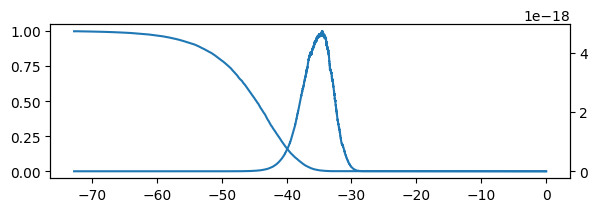

In [238]:
logL = np.array(samples.logL)
L = np.exp(logL)
logX = samples.logX()
X = np.exp(logX)

fig, ax1 = plt.subplots(figsize=(6.7,2))
ax2 = plt.twinx(ax1)
ax1.plot(logX, L)
ax2.plot(logX, L*X)

#### Single iteration

In [239]:
ndead = 10000
points = points_at_iteration(samples, ndead)
logL = np.array(points.logL)
nk = np.array(points.nlive)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [241]:
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
logZdead = logsumexp(points.logw()[:ndead])
logZlive = logZlive_formula(X_mean[ndead], theta_l)
logLmax = theta_l[0]
logXf_formula_approx(logZlive, logZdead, theta_l), logXf_formula(theta_l, logZdead, X_mean[ndead])

(-41.09198234845263, -40.75986982951096)

In [242]:
alphas = np.linspace(0, 1, 5)
theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
theta_best, theta_l

([-20.66691323278883, 9.781755230645073, 0.010075243643613493],
 [-15.242769365624248, 7.930157941443701, 0.006400524444972761])

#### Full run - bandwidth

In [268]:
N = 10
iterations = np.linspace(0.1*len(samples), len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
alphas = np.linspace(0, 1, 5)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logZlive = logZlive_formula(X_mean[ndead], theta_best)
    logXfs[i] = logXf_formula_approx(logZlive, logZdead, theta_best)

(0.0, 25000.0)

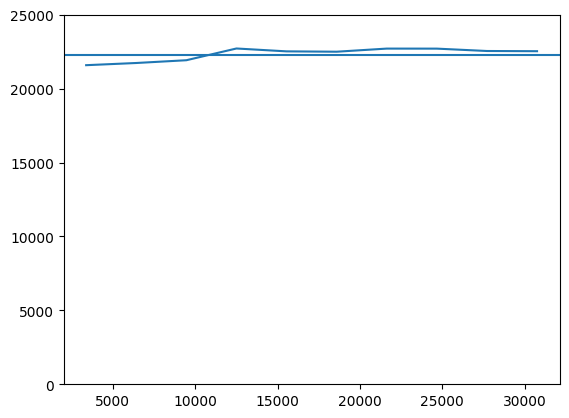

In [246]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(y=logXf_true * (-nlive))
plt.ylim(0, 25000)

In [247]:
N = 10
iterations = np.linspace(0.1*len(samples), len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
alphas = np.linspace(0, 1, 5)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logXfs[i] = logXf_formula(theta_best, logZdead, X_mean[ndead])

[-1.291e+01  9.830e+00  1.000e-02] warning 1.0
[-8.4   9.86  0.01] warning 1.0
[-5.98  9.88  0.01] warning 1.0
[-4.56  9.89  0.01] warning 1.0
[-3.66  9.9   0.01] warning 1.0
[-0.01  9.63  0.01] warning 0.25
[-3.06  9.91  0.01] warning 1.0
[-7.000e-02  1.006e+01  1.000e-02] warning 0.75
[-2.62  9.91  0.01] warning 1.0


(0.0, 25000.0)

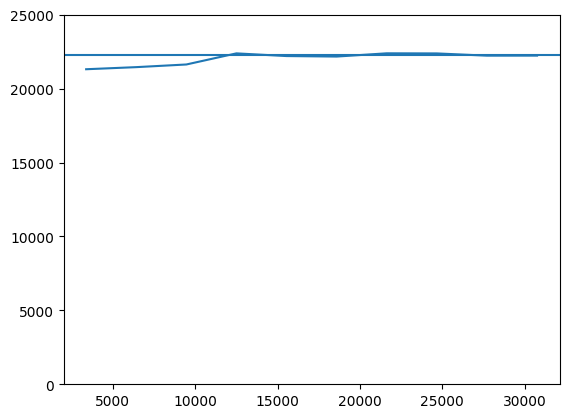

In [248]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(y=logXf_true * (-nlive))
plt.ylim(0, 25000)

### Wedding cake

#### Set up sample

In [243]:
from aeons.toy_samples import wedding_cake_samples
nlive = 500
d, sigma = 10, 0.01
samples = wedding_cake_samples(nlive, ndims=d, sigma=sigma)

In [244]:
kf = end_iteration(samples, 50, 0.5)
logXf_true = samples.logX()[kf]
logXf_true

-38.2524437311867

In [245]:
ndead = 13000
points = points_at_iteration(samples, ndead)
logL = np.array(points.logL)
L = np.exp(logL)
nk = np.array(points.nlive)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [246]:
alphas = np.linspace(0, 1, 10)
minimise_bandwidth(logL, X_mean, ndead, alphas, 1, give_alpha=1)

0.8888888888888888


[0.6276265004214565, 10.272938359778653, 0.019099550004725067]

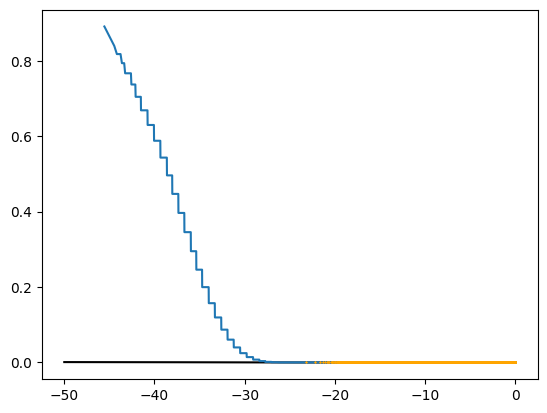

In [147]:
logXarray = np.linspace(-50, 0, 1000)
Xarray = np.exp(logXarray)
theta = minimise_bandwidth(logL, X_mean, ndead, [0.3], 1)
# plt.plot(X_mean, logL)
# plt.plot(X_mean, full.func(X_mean, theta))
plt.plot(logXarray, np.exp(full.func(Xarray, theta)), color='black')
plt.plot(samples.logX(), np.exp(samples.logL))
plt.plot(logX_mean, L, 'x', ms=1, color='orange')

#### Full run - bandwidth

In [233]:
N = 20
iterations = np.linspace(0.1*len(samples), len(samples), N, endpoint=False).astype(int)
logXfs_approx = np.zeros(N)
alphas = np.linspace(0, 1, 5)
# alphas = [0.3]
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logZlive = logZlive_formula(X_mean[ndead], theta_best)
    # print(logZdead, logZlive)
    logXfs_approx[i] = logXf_formula_approx(logZlive, logZdead, theta_best)

In [247]:
N = 20
iterations = np.linspace(0.1*len(samples), len(samples), N, endpoint=False).astype(int)
alphas = np.linspace(0, 1, 5)
logXfs = np.zeros(N)
logXfs_gaussian = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logXfs[i] = logXf_formula(theta_best, logZdead, X_mean[ndead])
    logXfs_gaussian[i] = logXf_formula_gaussian(theta_best)

(0.0, 24000.0)

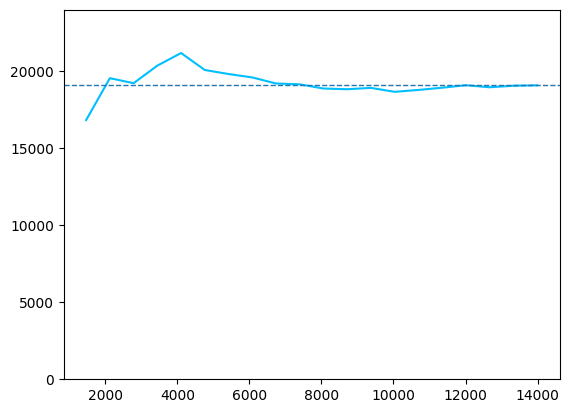

In [248]:
# plt.plot(iterations, logXfs_approx * (-nlive))
plt.plot(iterations, logXfs * (-nlive), color='deepskyblue')
# plt.plot(iterations, logXfs_gaussian * (-nlive), color='green')
plt.axhline(y=logXf_true * (-nlive), ls='--', lw=1)
plt.ylim(0, 24000)

#### Full run - no bandwidth

In [148]:
N = 50
iterations = np.linspace(0.1*len(samples), len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logXfs[i] = logXf_formula(theta_best, logZdead, X_mean[ndead])

(0.0, 30000.0)

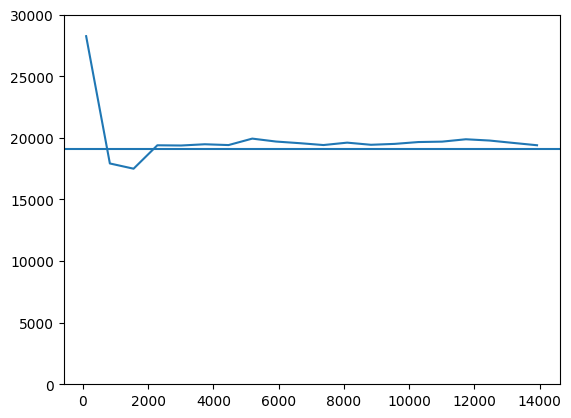

In [200]:
plt.plot(iterations, logXfs * (-nlive))
# plt.plot(iterations, logXfs_gaussian * (-nlive))
plt.axhline(y=logXf_true * (-nlive))
plt.ylim(0, 30000)

In [203]:
N = 20
iterations = np.linspace(100, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        # theta_l = analytic_lm_params(logL[ndead:], X[ndead:], 1)
        theta_l = minimise_bandwidth(logL, X, ndead, [0.5], 1)
        try:
            logZdead = logsumexp(points.logw()[:ndead])
            logXf_i.append(logXf_formula(theta_l, logZdead, X_mean[ndead]))
        except:
            print(theta_l, 'warning')
            continue
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

[44640.62901792533, 477.3624206184041, 0.0032988508596374887] warning


(0.0, 25000.0)

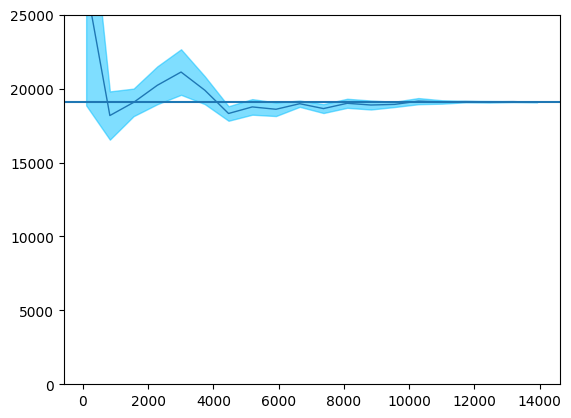

In [205]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
# plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.axhline(logXf_true * (-nlive))
plt.ylim(0, 25000)

#### Overpredicting Zlive

In [51]:
ndead = 12000
points = points_at_iteration(samples, ndead)
logL = np.array(points.logL)
L = np.exp(logL)
nk = np.array(points.nlive)
logX_mean = logX_mu(nk)
X_mean = X_mu(nk)

In [60]:
alphas = [0.4]
theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1, give_alpha=1)

0.4


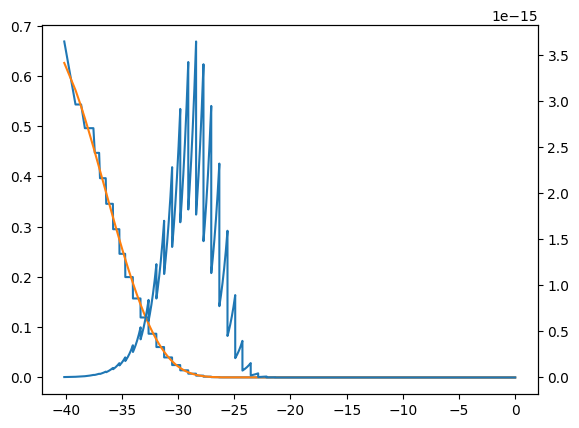

In [61]:
fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax1.plot(logX_mean, L)
ax1.plot(logX_mean, np.exp(full.func(X_mean, theta_best)))
# ax1.plot(logX_mean, np.exp(full.func(X_mean, theta_l)))
ax2.plot(logX_mean, L*X_mean)

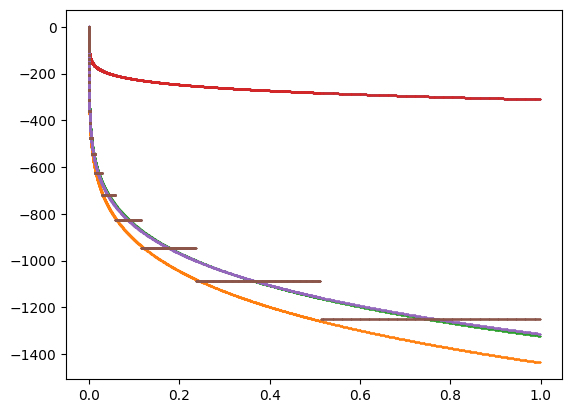

In [68]:
alphas = np.linspace(0, 1, 5)
for alpha in alphas:
    theta_best = minimise_bandwidth(logL, X_mean, ndead, [alpha], 1)
    plt.plot(X_mean, full.func(X_mean, theta_best), 'x', ms=1)
plt.plot(X_mean, logL, 'x', ms=1)    